# Fit a non-linear model to series data

In this example, we will fit the Ramberg-Osgood material model to steel tensile test results to demonstrate how to compute model parameters, and common steps in a tensile analysis.

## Connect to Granta MI

Specify a database and table.

Set the unit system explicitly to ensure repeatable results.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mpy

s = mpy.Session('http://localhost/mi_servicelayer', autologon=True)

db = s.get_db(db_key='MI_Training')
db.set_unit_system("Metric", absolute_temperatures=True)
test_data_table = db.get_table('Tensile Test Data')

## Get the folder containing test records

Records in the *Tensile Test Data* table are stored in folders grouped by *Test Temperature*. Get the parent folder to iterate through the different values of *Test Temperature*.

In [2]:
plate_record = test_data_table.get_records_from_path(None, ["High Alloy Steels", "AMS 6520"])[0]
temperature_test_groups = plate_record.children

print(f"Found {len(temperature_test_groups)} different Test Temperatures")
print(temperature_test_groups)

Found 6 different Test Temperatures
[<Record long name:1000°F>, <Record long name:-110°F>, <Record long name:300°F>, <Record long name:600°F>, <Record long name:800°F>, <Record long name:Room Temperature °F>]


## Fetch relevant attributes for the analysis using the Bulk Export tool

The attributes *Test Temperature* and *Tensile Response (11 axis)* are required for our analysis. Export both attributes plus the Pseudo-Attribute `Name` for efficiency. Store the record objects in a dictionary keyed by the test temperature, and extract the unit symbols for use when displaying results.

In [3]:
test_temperature = test_data_table.attributes["Test Temperature"]
temperature_unit = test_temperature.unit
tensile_response = test_data_table.attributes["Tensile Response (11 axis)"]
tensile_response_unit = tensile_response.unit
strain_unit = tensile_response.parameters["Strain"].unit
record_name = mpy.PseudoAttributeDefinition(name="name")

test_record_dict = {}
for test_group in temperature_test_groups:
    test_records = test_group.children
    fetcher = mpy.AttributeFetcher(test_data_table, attributes=[test_temperature, tensile_response, record_name], records=test_records)
    fetcher.fetch_attribute_data()

    temperature_attribute = test_records[0].attributes['Test Temperature']
    bucket_temperature = temperature_attribute.value
    test_record_dict[bucket_temperature] = {"records": test_records}
    print(f"Fetched attributes for {len(test_records)} records at {bucket_temperature:.1f}{temperature_unit}")

Fetched attributes for 6 records at 810.9K


Fetched attributes for 6 records at 194.3K


Fetched attributes for 6 records at 422.0K


Fetched attributes for 6 records at 588.7K


Fetched attributes for 6 records at 699.8K


Fetched attributes for 6 records at 296.1K


## Define the Ramberg-Osgood model

The Ramberg-Osgood model expresses the total stress as a function of the strain, the Elastic Modulus and two model parameters, conventionally `K` and `n`:

![Stress = (K + Strain/Elastic Modulus)*(n*Strain/Elastic Modulus)](img/RambergOsgood.svg 'Ramberg-Osgood equation')

In [4]:
import numpy as np

def ramberg_osgood_model(stress_: np.ndarray, modulus_: float, k_: float, n_: float) -> np.ndarray:
    hook_strain = stress_ / modulus_
    return hook_strain + k_ * hook_strain ** n_

## Define a helper function to fit the model to a series

Using the `scipy.optimize` package, fit the Ramberg-Osgood model to the stress-strain data at each temperature.

Provide initial values and constrain the parameters to positive and realistic values. These values are material dependent - for Steel we use the following:

| Parameter | Minimum | Maximum    | Initial Value |
|-----------|---------|------------|---------------|
| Modulus   | 1 MPa   | 10,000 MPa | 1,000 MPa     |
| K         | 0       | 100        | 1             |
| n         | 0       | 100        | 1             |

The goodness of fit can be estimated by inspecting the diagonal of the covariance matrix, which is returned by the `curve_fit` function. Take the square root to obtain the sum-of-squares error for each model parameter.

In [5]:
from typing import Tuple, List
from scipy.optimize import curve_fit

def fit_ramberg_osgood_model(stress_strain_data: np.ndarray) -> Tuple[np.ndarray, Tuple[float, float, float]]:
    parameter_bounds = ((1, 0, 0), (1e5, 1e2, 1e2))
    f_init = (1e3, 1, 1)

    stress = stress_strain_data[:, 0]
    strain = stress_strain_data[:, 1]

    fitted_parameters, covariance = curve_fit(
        ramberg_osgood_model,
        stress,
        strain,
        f_init,
        bounds=parameter_bounds
    )

    # Compute the sum-of-squared error for each model parameter
    sse = np.sqrt(np.diag(covariance))

    return fitted_parameters, sse

## Define additional helper functions

Define three more helper functions to make the main loop easier to understand:

* `get_response_data` iterates over the provided records and extracts the contents of the `Tensile Response (11 axis)` attribute into a numpy array.

* `compute_fitted_data` takes the fitted model parameters and a stress range and computes the predicted stress-strain curve. This is used to plot the model results.

* `compute_yield_point` takes a fitted stress-strain curve and the elastic modulus and performs a basic fit to calculate the 0.2% Offset Yield Stress and Strain of the material.

In [6]:
def get_response_data(records: List[mpy.Record]) -> np.ndarray:
    # Iterate through records, extract the appropriate attribute and ensure the units are set correctly
    test_response_attributes = []
    for record in records:
        tensile_response = record.attributes['Tensile Response (11 axis)']
        test_response_attributes.append(tensile_response)

    # Convert the AttributeValue objects into numpy arrays:
    # 1. Trim off the first row, which contains the column headers
    # 2. Cast each element to float (numpy treats these values as an object unless told otherwise)
    test_response_data = [np.array(attribute.value[1:]).astype(float) for attribute in test_response_attributes]

    # The Granta MI Scripting Toolkit stores all functional data as ranges. Since both values are the same, take the first.
    stress_strain_response = [np.column_stack((curve[1:, 0], curve[1:, 2])) for curve in test_response_data]
    return stress_strain_response

def compute_fitted_data(min_stress: float, max_stress: float, modulus: float, k: float, n: float) -> np.ndarray:
    num_fit_points = 100
    model_stress = np.linspace(min_stress, max_stress, num_fit_points)
    model_strain = ramberg_osgood_model(model_stress, modulus, k, n)
    return np.column_stack((model_stress, model_strain))

def compute_yield_point(stress_strain_data: np.ndarray, modulus: float) -> Tuple[float, float]:
    # Compute the difference between the provided stress-strain curve and the offset elastic stress-strain curve
    diff_stress = stress_strain_data[:, 0] - modulus * (stress_strain_data[:, 1] - 0.2)

    # Find the strain value where the offset elastic line intersects with the stress-strain curve
    yield_strain = np.interp(0, -diff_stress, stress_strain_data[:, 1])

    # Compute the yield stress
    yield_stress = modulus * (yield_strain - 0.2)
    return yield_stress, yield_strain

## Fit to the data

For each set of test records, extract the stress-strain curve and fit to the Ramberg-Osgood model using the helper functions defined above. Combine all the test runs into one dataset and fit the model to the aggregate data.

In your own scripts, you will also need to take into account multiple series, range data, and other features of your data such as `Estimated` and `Not-Applicable` flags.

In [7]:
import pprint

for test_temperature, tests_at_temperature in sorted(test_record_dict.items()):
    response_data = get_response_data(tests_at_temperature["records"])
    aggregate_response_data = np.row_stack(response_data)

    parameters, sse = fit_ramberg_osgood_model(aggregate_response_data)
    modulus, k, n = parameters

    min_stress = min(aggregate_response_data[:, 0])
    max_stress = max(aggregate_response_data[:, 0])
    model_stress_strain = compute_fitted_data(min_stress, max_stress, modulus, k, n)

    yield_stress, yield_strain = compute_yield_point(model_stress_strain, modulus)

    tests_at_temperature["response_data"] = response_data
    tests_at_temperature["fitted_model_data"] = model_stress_strain
    tests_at_temperature["model_parameters"] = {
        "modulus": modulus,
        "yield_point": (yield_strain, yield_stress),
        "k": k,
        "n": n
    }
    print(f"Fit parameters at Temperature {test_temperature:.1f}{temperature_unit}:")
    pprint.pprint(tests_at_temperature["model_parameters"])
    print("\n")

Fit parameters at Temperature 194.3K:
{'k': 0.14863494665834864,
 'modulus': 2062.020205175189,
 'n': 8.791864088304502,
 'yield_point': (1.2342202378666565, 2132.5830270821357)}


Fit parameters at Temperature 296.1K:
{'k': 0.17913268165526242,
 'modulus': 1981.6619869323374,
 'n': 9.114593929822345,
 'yield_point': (1.2120542799967224, 2005.5494953816813)}


Fit parameters at Temperature 422.0K:
{'k': 0.3068886077220345,
 'modulus': 1904.622970873033,
 'n': 8.456684278769352,
 'yield_point': (1.150551002526545, 1810.4412743984483)}


Fit parameters at Temperature 588.7K:
{'k': 0.46386736540632034,
 'modulus': 1825.4403088096124,
 'n': 8.486132296478962,
 'yield_point': (1.1055238434290011, 1652.979724383503)}


Fit parameters at Temperature 699.8K:
{'k': 0.4788380300246198,
 'modulus': 1720.6433384918525,
 'n': 7.16298785237091,
 'yield_point': (1.0851718223075149, 1523.0649994741193)}


Fit parameters at Temperature 810.9K:
{'k': 3.031055182426712,
 'modulus': 1501.6717764861335,
 '

## Plot the results

Plot the source data for each temperature run, with common axis scales to make comparison easier.

In addition to the response data and the fitted model, plot the elastic stress-strain line and the yield point at each temperature.

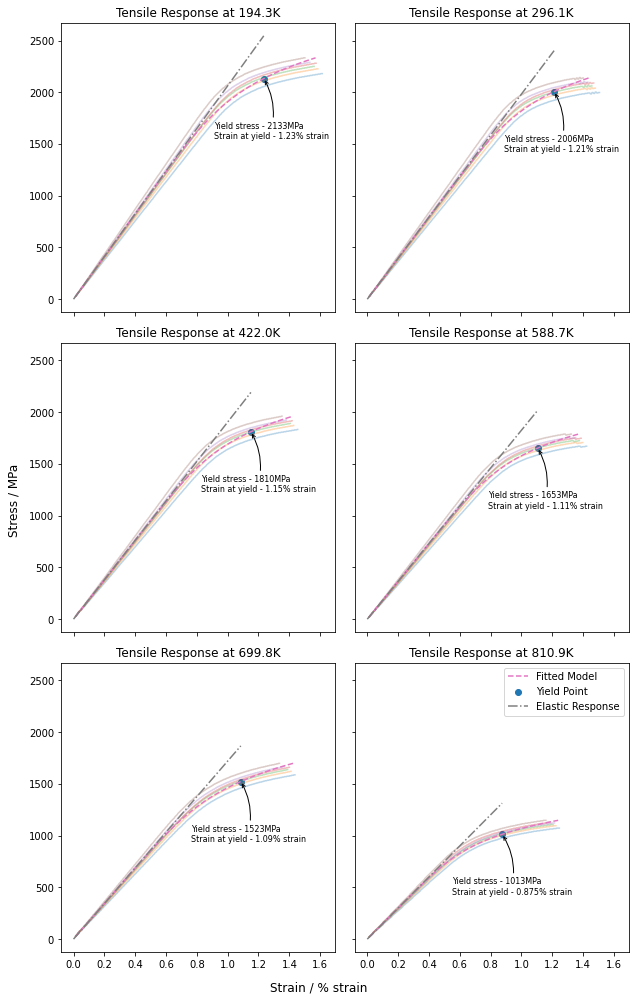

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 125
fig, axs = plt.subplots(3, 2, figsize=(9, 14), sharex='all', sharey='all')

fig.supylabel(f"Stress / {tensile_response_unit}")
fig.supxlabel(f"Strain / {strain_unit}")

current_plot_index = 0

for test_temperature, tests_at_temperature in sorted(test_record_dict.items()):
    response_data = tests_at_temperature["response_data"]
    model_parameters = tests_at_temperature["model_parameters"]

    ax_current = axs[current_plot_index // 2][current_plot_index % 2]
    ax_current.set_title(f"Tensile Response at {test_temperature:.1f}{temperature_unit}")

    # Plot source data series
    for series in response_data:
        ax_current.plot(
            series[:, 1], series[:, 0], alpha=0.3
        )

    # Plot fitted model
    fitted_data = tests_at_temperature["fitted_model_data"]
    fit_curve = ax_current.plot(fitted_data[:, 1], fitted_data[:, 0], '--', label="Fitted Model")

    # Add the yield point
    yield_strain, yield_stress = model_parameters["yield_point"]
    yield_curve = ax_current.scatter(yield_strain, yield_stress, label="Yield Point")
    ax_current.annotate(
        f"Yield stress - {yield_stress:.0f}{tensile_response_unit}\nStrain at yield - {yield_strain:.3}{strain_unit}",
        xy=model_parameters["yield_point"],
        xytext=(-50, -60),
        textcoords='offset points',
        size=8,
        arrowprops={
            "arrowstyle": "->",
            "connectionstyle": "arc3,rad=.2"
        }
    )

    # Add the elastic response line
    elastic_strain_region = [0., yield_strain]
    elastic_stress = [0., model_parameters["modulus"] * yield_strain]
    elastic_curve = ax_current.plot(elastic_strain_region, elastic_stress, '-.', label="Elastic Response")

    # Add Legend to last subplot (where there is more whitespace)
    if current_plot_index == 5:
        ax_current.legend()

    current_plot_index = current_plot_index + 1

plt.tight_layout()